In [152]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import sympy as sp
print("test")

In [153]:
def kalman(x0, y, P, Q, R, C):
    """
    Paramètre:
    x0 : etat initial
    y : observation bruité
    P : matrice de covariance de l'état initial
    Q : matrice de covariance du bruit du processus
    R : matrice de covariance du bruit des mesures
    C : matrice de mesure (g)
    
    Retourne:
    Le signal filtré
    """
    x = np.zeros(y.shape)
    x[:, 0] = x0.reshape((x.shape[0],))
    I = np.eye(18)
    
    for i in range(y.shape[1]-1):
        
        A = I
        b = np.dot(np.linalg.inv(I / dt - 1 / 2 * jacobien_diff_finies(x[:, i])), F(x[:, i]))
        
        #correction 
        r = y[:,i] - C.dot(x[:, i]) #ecart entre la mesure et le modèle théorique (xk moins)
        K = np.dot(P.dot(C.T), np.linalg.inv(np.dot(C.dot(P), C.T) + R)) #gain

        #etat du système
        x[:, i] += K.dot(r) #xk moins devient xk plus
        x[:, i+1] = (A.dot(x[:, i].reshape((x[:, i].shape[0], 1))) + b).reshape((b.shape[0],)) #calcul de xk_plus_un_moins
        
        #mise à jour de P
        P = P - np.dot(K, C.dot(P)) #calcul de Pk_plus
        P = np.dot(A.dot(P), A.T) + Q #calcul de Pk_plus_un_moins
    
    return x


In [154]:
#Permet de tracer la gaussienne une fois les paramètres déterminés
def gaussienne(alpha, b, m, val_theta, omega):
    """
    Paramètre:
    alpha, b, m: liste des 5 valeurs de alpha pour les diff gaussiennes
    val_theta : liste des points où l'on doit trouver la valeur
    Retourne:
    val : La valeur de la somme des gaussienne aux points val_theta
    (sum_i alpha[i] * exp(-(theta[i]-val_theta)**2/(2*b[i]**2)))
    """
    val = []
    
    #Boucle sur les points d'abscisse
    for theta in val_theta:
        S=0 # pour la somme des gaussiennes à chaque theta
        for i in range(5): # on somme chacune des gaussiennes
            delta_theta_i = (theta - m[i]) % (2 * np.pi)
            S += (alpha[i] * delta_theta_i) / (b[i] ** 2) * np.exp(-delta_theta_i ** 2 / (2 * b[i] ** 2))

        #On ajoute la valeur de la somme S à val
        val.append(S)
    
    return val

In [155]:
#Fonction F
def F(X):
    """
    X = (z, theta, (alpha_i)*5, (b_i)*5, (m_i)*5, omega)
    """
    z = X[0]
    theta = X[1]
    alpha = X[2:7]
    b = X[7:12]
    m = X[12:17]
    omega = X[17]
    S=0 # pour la somme des gaussiennes
    for i in range(5): # on somme chacune des gaussiennes
        delta_theta_i = (theta - m[i]) % (2 * np.pi)
        S += (alpha[i] * delta_theta_i) / (b[i] ** 2) * np.exp(-delta_theta_i ** 2 / (2 * b[i] ** 2))

    return np.array([[S], [omega],   [0],[0],[0],[0],[0],   [0],[0],[0],[0],[0],    [0],[0],[0],[0],[0],   [0]])


In [156]:
def jacobien_diff_finies(X, h=1e-5):

    n = len(X)  # Nombre de variables
    J = np.zeros((n, n))  # Initialisation du jacobien

    for i in range(n):
        X_plus_h = np.copy(X)
        X_minus_h = np.copy(X)
        X_plus_h[i] += h
        X_minus_h[i] -= h

        # Calcul de la dérivée partielle avec différences finies centrées
        diff = (F(X_plus_h) - F(X_minus_h)) / (2 * h)
        J[:, i] = diff.reshape((18,))

    return J


In [161]:
#Simulation de 5 gaussiennes bruitées

#Paramètres des gaussiennes
alpha = [1.3, -0.5, 3.5, -1.5, 2]     #amplitude
b = [0.2 ,0.4, 0.25, 0.18, 0.4]        #écart type
m = [-1.5, -0.7, 0, 0.7, 1.75]   #moyenne, theta_i
omega = 1.7

#Abscisse du tracé
N=400
val_theta = np.linspace(-np.pi, np.pi, N)
dt = 2 * np.pi / omega * 1 /(N+1)

#Valeur de la somme des gaussiennes
val_gaussienne = gaussienne(alpha, b, m, val_theta, omega)

#Paramètre du bruit
max_amplitude = max(abs(val) for val in val_gaussienne)
niveau_bruit = 0.05
mu = 0
sigma_bruit = max_amplitude * niveau_bruit

#bruitage des données, creation de y
val_gaussienne = [val + np.random.normal(mu, sigma_bruit) for val in val_gaussienne]
val_theta = [theta + np.random.normal(mu, sigma_bruit)/100 for theta in val_theta]
liste_omega = [omega + np.random.normal(mu, sigma_bruit) for i in range(len(val_gaussienne))]

liste_alpha_brute = [[x + np.random.normal(mu, sigma_bruit) for x in alpha] for _ in range(len(val_gaussienne))]
liste_b_brute = [[x + np.random.normal(mu, sigma_bruit) for x in b] for _ in range(len(val_gaussienne))]
liste_m_brute = [[x + np.random.normal(mu, sigma_bruit) for x in m] for _ in range(len(val_gaussienne))]
# Restructurer les listes pour regrouper les ièmes éléments
liste_alpha = [[liste[i] for liste in liste_alpha_brute] for i in range(len(alpha))]
liste_b = [[liste[i] for liste in liste_b_brute] for i in range(len(b))]
liste_m = [[liste[i] for liste in liste_m_brute] for i in range(len(m))]

y = np.array([val_gaussienne, val_theta, *liste_alpha, *liste_b, *liste_m, liste_omega])

In [162]:
#Simulation

#création de la donné initiale x0, v0, k0
x0 = np.ones((18, 1))

#création de la matrice de mesure
C = np.eye(18)

#matrice de covariance du bruit
P = niveau_bruit * np.eye(18) 
Q = sigma_bruit * np.eye(18)
R = niveau_bruit/10 * np.eye(18)

#application du filtre de kalman
X_filtre = kalman(x0, y, P, Q, R, C)

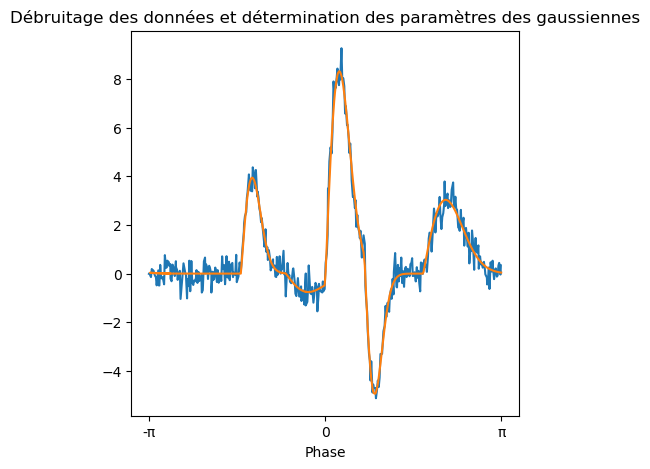

[ 1.38325047 -0.48249754  3.79485694 -1.46558025  1.92942625  0.32379323
  0.66468781  0.06919573  0.44102135  0.52284961 -1.3707922  -1.057659
  0.2845097   0.65666441  1.88261232  2.02142498]


In [163]:
#On récupère les valeurs déterminé des coefficients

def recup_para(X_filtre, nb_point=5):
    """
    X_filtre : application du filtre de kalman 
    nb_point : nombre de point sur lequel on fait la moyenne des paramètres
    Retourne : une moyenne des alpha, b, m, omega déterminés
    """
    return np.mean(X_filtre[2:, -nb_point:], axis=1)

#Tracé des données et comparaison
plt.figure(figsize=(5,5))
plt.plot(val_theta, val_gaussienne, label='Donnée mesurée')
plt.plot(X_filtre[1], gaussienne(alpha, b, m, X_filtre[1], omega), label='Donnée filtrée')
#plt.plot(X_filtre[1], X_filtre[0], label='donnée filtrée')
plt.xlabel('Phase')
plt.xticks([-np.pi, 0, np.pi], ['-π', '0', 'π'])
plt.title("Débruitage des données et détermination des paramètres des gaussiennes")
plt.show()


print(recup_para(X_filtre))

In [166]:
#animation avec des sliders

#créer le vecteur y
def creer_y(alpha, b, m):
    
    omega = 1.7

    #Abscisse du tracé
    N=400
    val_theta = np.linspace(-np.pi, np.pi, N)
    dt = 2 * np.pi / omega * 1 /(N+1)

    #Valeur de la somme des gaussiennes
    val_gaussienne = gaussienne(alpha, b, m, val_theta, omega)

    #Paramètre du bruit
    max_amplitude = max(abs(val) for val in val_gaussienne)
    niveau_bruit = 0.05
    mu = 0
    sigma_bruit = max_amplitude * niveau_bruit

    #bruitage des données, creation de y
    val_gaussienne = [val + np.random.normal(mu, sigma_bruit) for val in val_gaussienne]
    val_theta = [theta + np.random.normal(mu, sigma_bruit)/100 for theta in val_theta]
    liste_omega = [omega + np.random.normal(mu, sigma_bruit) for i in range(len(val_gaussienne))]

    liste_alpha_brute = [[x + np.random.normal(mu, sigma_bruit) for x in alpha] for _ in range(len(val_gaussienne))]
    liste_b_brute = [[x + np.random.normal(mu, sigma_bruit) for x in b] for _ in range(len(val_gaussienne))]
    liste_m_brute = [[x + np.random.normal(mu, sigma_bruit) for x in m] for _ in range(len(val_gaussienne))]
    # Restructurer les listes pour regrouper les ièmes éléments
    liste_alpha = [[liste[i] for liste in liste_alpha_brute] for i in range(len(alpha))]
    liste_b = [[liste[i] for liste in liste_b_brute] for i in range(len(b))]
    liste_m = [[liste[i] for liste in liste_m_brute] for i in range(len(m))]

    y = np.array([val_gaussienne, val_theta, *liste_alpha, *liste_b, *liste_m, liste_omega])
    
    return y



# Fonction pour afficher et mettre à jour en fonction des para des gaussiennes
def Kalman_interactif(m1, m2, m3, m4, m5, b1, b2, b3, b4, b5, alpha1, alpha2, alpha3, alpha4, alpha5):

    alpha = [alpha1, alpha2, alpha3, alpha4, alpha5]
    b = [b1, b2, b3, b4, b5]
    m = [m1, m2, m3, m4, m5]
    
    #application du filtre de kalman
    y = creer_y(alpha, b, m)
    val_gaussienne = y[0]
    val_theta = y[1]
    X_filtre = kalman(x0, y, P, Q, R, C)

    #Tracé des données et comparaison
    plt.figure(figsize=(5,5))
    plt.plot(val_theta, val_gaussienne, label='Donnée mesurée')
    plt.plot(X_filtre[1], gaussienne(alpha, b, m, X_filtre[1], omega), label='Donnée filtrée')
    plt.xlabel('Phase')
    plt.xticks([-np.pi, 0, np.pi], ['-π', '0', 'π'])
    plt.title("Débruitage des données et détermination des paramètres des gaussiennes")
    plt.show()

    
# Créer le slider pour m1
m1_slider = widgets.FloatSlider(
    value=-1.5,
    min=-2.5,
    max=2.5,
    step=0.1,
    description='m1:',
    continuous_update=True
)
# Créer le slider pour m2
m2_slider = widgets.FloatSlider(
    value=-0.5,
    min=-2.5,
    max=2.5,
    step=0.1,
    description='m2:',
    continuous_update=True
)
# Créer le slider pour m3
m3_slider = widgets.FloatSlider(
    value=0,
    min=-2.5,
    max=2.5,
    step=0.1,
    description='m3:',
    continuous_update=True
)
# Créer le slider pour m4
m4_slider = widgets.FloatSlider(
    value=0.3,
    min=-2.5,
    max=2.5,
    step=0.1,
    description='m4:',
    continuous_update=True
)
# Créer le slider pour m5
m5_slider = widgets.FloatSlider(
    value=1.4,
    min=-2.5,
    max=2.5,
    step=0.1,
    description='m5:',
    continuous_update=True
)

# Créer le slider pour b1
b1_slider = widgets.FloatSlider(
    value=0.2,
    min=0.01,
    max=0.5,
    step=0.05,
    description='sigma1:',
    continuous_update=True
)
# Créer le slider pour b2
b2_slider = widgets.FloatSlider(
    value=0.3,
    min=0.01,
    max=0.5,
    step=0.05,
    description='sigma2:',
    continuous_update=True
)
# Créer le slider pour b3
b3_slider = widgets.FloatSlider(
    value=0.15,
    min=0.01,
    max=0.5,
    step=0.05,
    description='sigma3:',
    continuous_update=True
)
# Créer le slider pour b4
b4_slider = widgets.FloatSlider(
    value=0.4,
    min=0.01,
    max=0.5,
    step=0.05,
    description='sigma4:',
    continuous_update=True
)
# Créer le slider pour b5
b5_slider = widgets.FloatSlider(
    value=0.3,
    min=0.01,
    max=0.5,
    step=0.05,
    description='sigma5:',
    continuous_update=True
)

# Créer le slider pour alpha1
alpha1_slider = widgets.FloatSlider(
    value=0.5,
    min=-3,
    max=3,
    step=0.1,
    description='alpha1:',
    continuous_update=True
)
# Créer le slider pour alpha2
alpha2_slider = widgets.FloatSlider(
    value=-0.8,
    min=-3,
    max=3,
    step=0.1,
    description='alpha2:',
    continuous_update=True
)
# Créer le slider pour alpha3
alpha3_slider = widgets.FloatSlider(
    value=2,
    min=-3,
    max=3,
    step=0.1,
    description='alpha3:',
    continuous_update=True
)
# Créer le slider pour alpha4
alpha4_slider = widgets.FloatSlider(
    value=-0.5,
    min=-3,
    max=3,
    step=0.1,
    description='alpha4:',
    continuous_update=True
)
# Créer le slider pour alpha5
alpha5_slider = widgets.FloatSlider(
    value=0.5,
    min=-3,
    max=3,
    step=0.1,
    description='alpha5:',
    continuous_update=True
)



# Interagir avec le slider
widgets.interactive(Kalman_interactif, m1=m1_slider, m2=m2_slider, m3=m3_slider, m4=m4_slider, m5=m5_slider, b1=b1_slider, b2=b2_slider, b3=b3_slider, b4=b4_slider, b5=b5_slider, alpha1=alpha1_slider, alpha2=alpha2_slider, alpha3=alpha3_slider, alpha4=alpha4_slider, alpha5=alpha5_slider)

interactive(children=(FloatSlider(value=-1.5, description='m1:', max=2.5, min=-2.5), FloatSlider(value=-0.5, d…